In [134]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [159]:
class Network:
    def __init__(self, layers = [784, 500, 300, 10]):
        self.layers = layers
        self.weights = []
        self.masks = []
        self.weights_dim = [[layers[i], layers[i+1]] for i in range(len(layers) - 1)]
        self.protected = [[0] * layer for layer in layers]
        self.deaths = [[0] * layer for layer in layers]
        for i in self.weights_dim:
            self.masks.append(tf.placeholder(tf.float32, i))
            self.weights.append(
                [tf.Variable(tf.random_uniform(i, -3./i[0]**0.5, 3./i[0]**0.5)), tf.Variable(tf.zeros(i[1:]))])
        self.session = tf.Session()
    
    def build_graph(self):
        x = self.x = tf.placeholder(tf.float32, [None, self.layers[0]])
        y_ = self.y_ = tf.placeholder(tf.float32, [None, self.layers[-1]])
        
        y = x
        for w, b in self.weights[:-1]:
            y = tf.nn.sigmoid(tf.matmul(y, w) + b)
            
        w, b = self.weights[-1]
        y = tf.nn.softmax(tf.matmul(y, w) + b)
        
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        self.correct_rate = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
        error = cross_entropy + 0.1 * tf.nn.l2_loss([tf.reduce_mean(weight[0]) for weight in self.weights])
        self.train_step = tf.train.AdadeltaOptimizer(0.1).minimize(error)
        
        #Brain damage
        self.delete_neurons = []
        for i in range(len(self.weights)):
            self.delete_neurons.append(tf.assign(self.weights[i][0], self.masks[i]))
            
        self.init = tf.initialize_all_variables()
        
    def brain_damage(self, layer, low_rate, high_rate, protection = 3):
        W = self.session.run(self.weights[layer][0])
#        print(W.shape)
        wsum = list(np.sum(np.absolute(W), axis = 1))
        wsorted = sorted([(i, wsum[i]) for i in range(len(wsum))], key = lambda x: x[1])
        wsorted = list(filter(lambda x: self.protected[layer][x[0]] == 0, wsorted))
        
        for i in range(len(self.protected[layer])):
            if self.protected[layer][i] > 0:
                self.protected[layer][i] -= 1
        
        indexes = [x[0] for x in wsorted]
        to_delete = indexes[:int(low_rate * len(wsorted))] + indexes[int(high_rate * len(wsorted)):]
        for i in to_delete:
            self.protected[layer][i] = protection
            self.deaths[layer][i] += 1
#        print(to_delete)
        mask_out = self.weights[layer][0].eval(session=self.session)
        #mask_out = mask_out / np.max(np.abs(mask_out)) * 0.25
        mask_in = self.weights[layer - 1][0].eval(session=self.session)
        #mask_in = mask_in / np.max(np.abs(mask_in)) * 0.25
        for i in to_delete:
            for j in range(self.weights_dim[layer][1]):
                mask_out[i, j] = mask_out[i, j] 
            for j in range(self.weights_dim[layer - 1][0]):
                mask_in[j, i] = np.random.uniform(-0.1, 0.1)
                
        self.session.run(self.delete_neurons[layer], feed_dict = {self.masks[layer] : mask_out})
        self.session.run(self.delete_neurons[layer - 1], feed_dict = {self.masks[layer - 1] : mask_in})
        
    def init_variables(self):
        self.session.run(self.init)
        
    def train(self, steps):
        for i in range(steps):
            if (i + 1) % 1000 == 0:
                print('step:', i, self.validate())
            batch_xs, batch_ys = mnist.train.next_batch(100)
            self.session.run(self.train_step, feed_dict = {self.x : batch_xs, self.y_ : batch_ys})
            
    def layer_utility(self, layer):
        W = self.session.run(self.weights[layer][0])
        wsum = list(np.sum(np.absolute(W), axis = 1))
        plt.hist(wsum, bins = 20)
            
    def validate(self):
        return self.session.run(self.correct_rate, feed_dict={self.x: mnist.test.images, self.y_: mnist.test.labels})
    
    def delete_layer(self, layer):
        self.session.run(self.delete_neurons[layer], feed_dict = {self.masks[layer] : np.zeros(self.weights_dim[layer])})
     
    def restore_layer(self, layer):
        self.session.run(self.delete_neurons[layer], feed_dict = {self.masks[layer] : np.ones(self.weights_dim[layer])})
        
    def score(self, layer, top):
        W = self.session.run(self.weights[layer][0])
#        print(W.shape)
        wsum = list(np.sum(np.absolute(W), axis = 1))
        wsorted = sorted([(i, wsum[i]) for i in range(len(wsum))], key = lambda x: x[1])
        
        for x in wsorted[:top]:
            print(x)
            
        

In [160]:
n = Network()
n.build_graph()
n.init_variables()
n.train(5000)

step: 999 0.8899
step: 1999 0.9073
step: 2999 0.9181
step: 3999 0.9185
step: 4999 0.9241


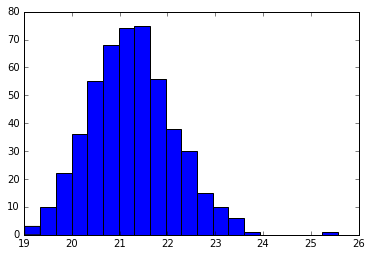

In [161]:
n.layer_utility(1)

In [162]:
n.score(1, 10)

(470, 19.014986)
(391, 19.188908)
(334, 19.261688)
(307, 19.373735)
(280, 19.449894)
(35, 19.474127)
(314, 19.49543)
(293, 19.508171)
(384, 19.54916)
(427, 19.563101)


In [170]:
previous_step = -100 
low_rate = 0.0
high_rate = 0.10
rate_decay = 1.0
for i in range(5):
    n.brain_damage(1, low_rate, high_rate, 2)
    n.brain_damage(2, low_rate, high_rate, 2)
    n.train(10000)
    current_step = n.validate()
    rate = rate * rate_decay
    print(i, ':', current_step)
    n.score(1, 10)

step: 999 0.9284
step: 1999 0.9337
step: 2999 0.9397
step: 3999 0.9419
step: 4999 0.9462
step: 5999 0.9476
step: 6999 0.949
step: 7999 0.9519
step: 8999 0.9555
step: 9999 0.9576
0 : 0.9573
(143, 13.355614)
(447, 13.775244)
(343, 13.898643)
(131, 14.017754)
(297, 14.049238)
(291, 14.052413)
(445, 14.061562)
(254, 14.198777)
(96, 14.221506)
(454, 14.224924)
step: 999 0.957
step: 1999 0.9597
step: 2999 0.9627
step: 3999 0.9625
step: 4999 0.9637
step: 5999 0.9643
step: 6999 0.9632
step: 7999 0.9655
step: 8999 0.9656
step: 9999 0.9669
1 : 0.9669
(143, 13.715855)
(447, 13.71712)
(445, 13.997372)
(343, 14.022764)
(131, 14.054689)
(297, 14.082634)
(254, 14.178088)
(291, 14.186419)
(405, 14.217693)
(96, 14.223932)
step: 999 0.8878
step: 1999 0.9086
step: 2999 0.9174
step: 3999 0.9199
step: 4999 0.9277
step: 5999 0.9311
step: 6999 0.9318
step: 7999 0.9341
step: 8999 0.9403
step: 9999 0.9401
2 : 0.9401
(118, 13.947402)
(181, 14.528141)
(264, 14.615751)
(189, 14.641109)
(483, 14.685255)
(108, 14.7

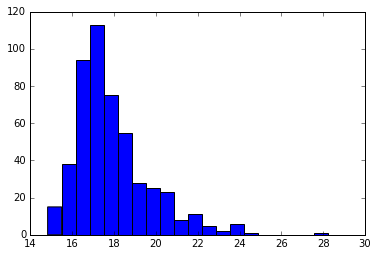

In [167]:
n.layer_utility(1)

(array([ 255.,    0.,    0.,  194.,    0.,    0.,   47.,    0.,    0.,    4.]),
 array([ 4. ,  4.3,  4.6,  4.9,  5.2,  5.5,  5.8,  6.1,  6.4,  6.7,  7. ]),
 <a list of 10 Patch objects>)

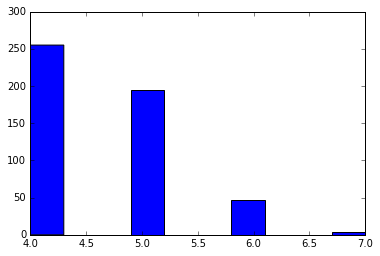

In [168]:
plt.hist(n.deaths[1])

In [90]:
n.score(1)
n.brain_damage(1, 0.2)

[(14, 7.6016097), (72, 7.8997364), (57, 8.2414942), (47, 8.2550325), (2, 8.3643837), (13, 8.4130831), (97, 8.4813261), (20, 8.6795397), (89, 8.6867123), (60, 8.7762775), (54, 8.797473), (94, 8.9162798), (53, 8.9847145), (43, 9.0994005), (99, 9.1403255), (75, 9.1865635), (52, 9.2018747), (78, 9.2499857), (92, 9.3107061), (51, 9.3445415), (15, 9.3849087), (66, 9.4066477), (35, 9.4142294), (42, 9.4566374), (1, 9.4957762), (44, 9.511755), (79, 9.5213156), (69, 9.5650539), (38, 9.6119528), (83, 9.6306372), (25, 9.6355219), (22, 9.6356421), (80, 9.6759548), (23, 9.7499056), (19, 9.7555513), (65, 9.7824049), (61, 9.8653841), (58, 9.8977833), (11, 9.927331), (68, 9.9316044), (76, 9.9408846), (41, 9.9508448), (10, 9.9621086), (98, 9.9736109), (73, 10.018256), (82, 10.03371), (70, 10.080753), (30, 10.109867), (95, 10.116479), (48, 10.119434), (86, 10.135349), (39, 10.171138), (87, 10.267855), (77, 10.306024), (91, 10.316617), (27, 10.330379), (62, 10.354987), (34, 10.400938), (9, 10.456761), (88

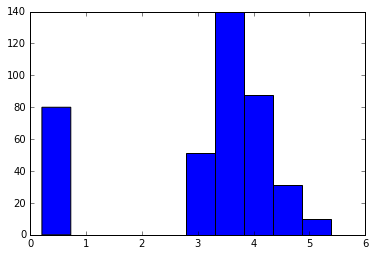

In [34]:
n.layer_utility(1)

In [35]:
n.train(5000)

step: 999 0.9561
step: 1999 0.9573
step: 2999 0.9572
step: 3999 0.9573
step: 4999 0.9576


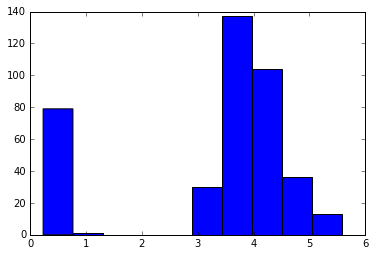

In [36]:
n.layer_utility(1)

In [37]:
n.train(5000)

step: 999 0.958
step: 1999 0.9582
step: 2999 0.9587
step: 3999 0.958
step: 4999 0.9585


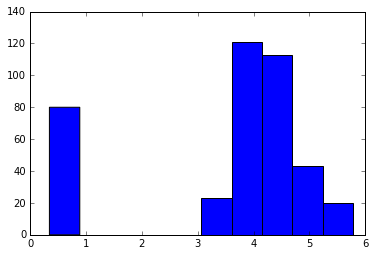

In [38]:
n.layer_utility(1)

In [ ]:
n.session.run(n.weights[1][0])